In [1]:
import os
import cv2
import numpy as np
import torch # 1.9
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.nn import functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations as A

In [2]:
from dataset import getAllDataPath, CustomImageDataset, show_image
from unet import UNet
from loss import DiceLoss, FocalLoss

In [3]:
BATCH_SIZE = 8
WIDTH = 256
HEIGHT = 256
device = 'cuda:0'

In [4]:
# https://albumentations.ai/docs/getting_started/mask_augmentation/

transform = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(brightness_limit=[-0.05, 0.05], p=0.2),
#     A.Rotate((-30, 30), interpolation=0), 
#     A.RandomContrast(limit=0.2, p=1), 

    A.Resize(WIDTH, HEIGHT),
])

target_transform = A.Compose([                       
    A.Resize(WIDTH, HEIGHT),
])

In [5]:
root = './data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/CT/'
CT_data = getAllDataPath(root, test_split_size=0.2)
root = './data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/MRI/MRI_Label/'
MRI_data = getAllDataPath(root, test_split_size=0.2)
root = './data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/MRI/MRI_nonLabel/'
MRI_imgOnly_data = getAllDataPath(root, imgOnly=True)

for data in ['CT_data', 'MRI_data', 'MRI_imgOnly_data']:
    i = eval(data)
    for k in i.keys():
        print(data,k, np.shape(i[k]))


dataset_train = CustomImageDataset(MRI_data['train'], transform=transform)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

dataset_test = CustomImageDataset(MRI_data['test'], transform=target_transform) # **如果要正式使用要記得把這裡換成X_test
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

CT_dataset_train = CustomImageDataset(CT_data['train'], transform=transform)
CT_dataloader_train = torch.utils.data.DataLoader(CT_dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

CT_dataset_test = CustomImageDataset(CT_data['test'], transform=target_transform)
CT_dataloader_test = torch.utils.data.DataLoader(CT_dataset_test, batch_size=BATCH_SIZE, shuffle=False)

CT_data train (2299, 2)
CT_data test (575, 2)
MRI_data train (123, 2)
MRI_data test (31, 2)
MRI_imgOnly_data train (309,)


torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([45744, 12497,  3443,  1465,   662,   544,   420,   356,   292,
         113]), array([0.        , 0.09841475, 0.1968295 , 0.29524425, 0.393659  ,
       0.49207374, 0.5904885 , 0.6889032 , 0.787318  , 0.88573277,
       0.9841475 ], dtype=float32)) tensor([0.])


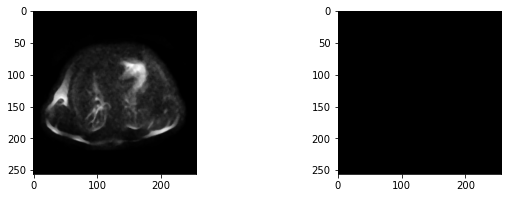

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([46566, 10419,  4388,  1998,   816,   491,   480,   214,   112,
          52]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
      dtype=float32)) tensor([0., 1.])


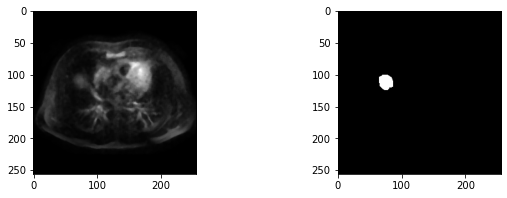

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([40942, 10708,  5581,  4506,  1499,  1010,   604,   599,    44,
          43]), array([0.        , 0.09993327, 0.19986655, 0.29979983, 0.3997331 ,
       0.49966636, 0.59959966, 0.6995329 , 0.7994662 , 0.89939946,
       0.9993327 ], dtype=float32)) tensor([0., 1.])


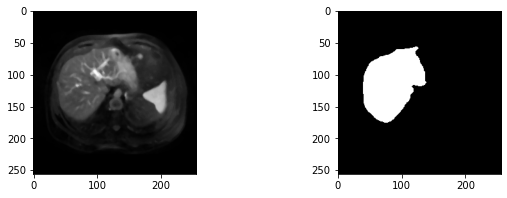

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([42985, 12208,  4533,  1578,   940,  1334,  1601,   261,    71,
          25]), array([0.        , 0.09977923, 0.19955845, 0.2993377 , 0.3991169 ,
       0.49889612, 0.5986754 , 0.69845456, 0.7982338 , 0.898013  ,
       0.99779224], dtype=float32)) tensor([0., 1.])


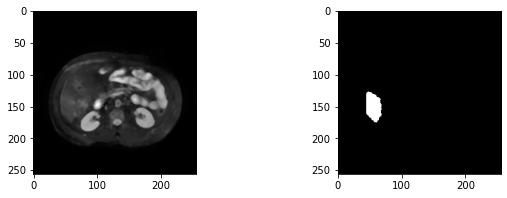

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([50252,  4879,  5717,  2185,  2285,    78,    41,    24,    24,
          51]), array([0.        , 0.09996814, 0.19993627, 0.2999044 , 0.39987254,
       0.49984068, 0.5998088 , 0.69977695, 0.7997451 , 0.8997132 ,
       0.99968135], dtype=float32)) tensor([0., 1.])


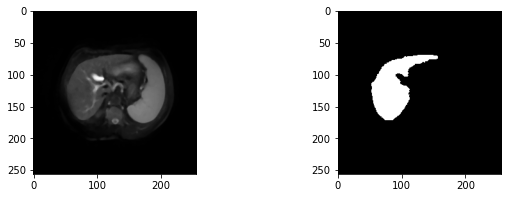

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([49439,  8019,  3475,  1318,  2424,   539,    80,    96,    60,
          86]), array([0.        , 0.09971638, 0.19943276, 0.29914913, 0.39886552,
       0.4985819 , 0.59829825, 0.6980146 , 0.79773104, 0.8974474 ,
       0.9971638 ], dtype=float32)) tensor([0., 1.])


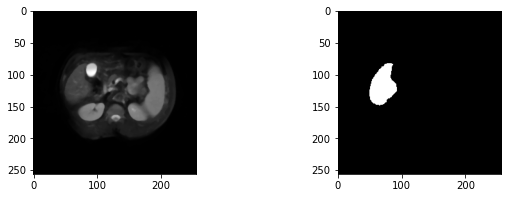

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([47329,  8911,  5575,  1934,  1029,   555,   171,    11,    10,
          11]), array([0.        , 0.09960076, 0.19920152, 0.2988023 , 0.39840305,
       0.4980038 , 0.5976046 , 0.6972053 , 0.7968061 , 0.8964069 ,
       0.9960076 ], dtype=float32)) tensor([0.])


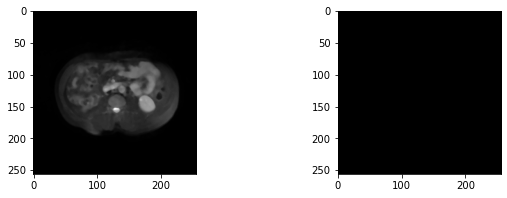

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([44349,  6081,  4616,  2995,  3869,  2895,   614,    80,    27,
          10]), array([0.        , 0.09887053, 0.19774106, 0.2966116 , 0.39548212,
       0.49435267, 0.5932232 , 0.69209373, 0.79096425, 0.8898348 ,
       0.98870534], dtype=float32)) tensor([0., 1.])


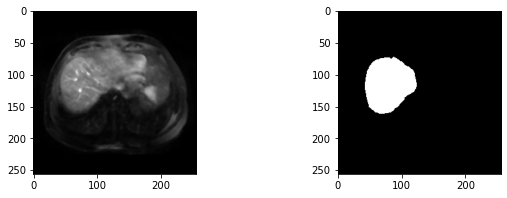

In [14]:
'''
Abs: test transform on dataloader_train.
---
take first image in every batch.
'''
for data in dataloader_train:
    for x, y in zip(*data): 
        print(x.shape, y.shape)
        print(np.histogram(x.numpy()), y.unique())
        show_image(x.squeeze(0).numpy(), y.squeeze(0).numpy())
        
    break

In [7]:
'''
title: create model
---
補充:
- 要在建立optimizer之前就把model的參數移到gpu裡面(也就是在把參數託管給optim以前)
ref: https://pytorch.org/docs/stable/optim.html 
'''

model = UNet
model = model((WIDTH, HEIGHT), in_ch=1, out_ch=1, activation=None).to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-2)

In [8]:
'''
abs: training model
---
- 下面的程序會在3種條件下儲存當前的model(只包含weight)
    - 當前模型的loss是目前以來最低
    - 當前epoch數是20的倍數
    - 完成一個epoch的訓練
'''
from torchvision.ops import sigmoid_focal_loss

EPOCHS = 300
min_target_loss_value = 100
save_root = './data/save_weights/'
os.makedirs(save_root, exist_ok=True)

for epoch in range(EPOCHS):  
    class_loss_value = 0.0

    for i, (source_data, source_label) in enumerate(dataloader_train):
        # zero the parameter gradients
        '''
        abs: zero the parameter gradients
        ---
        這兩種方法都能夠清除variable內的gradient:
        方法1
        param in model.parameters():
        param.grad = None
        方法2 借助optimizer尋找關聯的variable並清除gradient
        optimizer.zero_grad()
        '''
        optimizer.zero_grad()
    
        source_data = source_data.to(device)
        source_label = source_label.to(device)
        
        outputs = model(source_data)
        '''
        abs: single channel'
        ---
        Note:
        - If DiceLloss, outputs = F.sigmoid(outputs)
        - If BCEWithLogitsLoss, outputs不須activation
        '''
#         
#         loss = DiceLoss()(outputs, source_label)
#         loss = torch.nn.MSELoss()(outputs, source_label)
#         loss = torch.nn.BCEWithLogitsLoss(pos_weight = torch.Tensor([100]).to(device))(outputs, source_label)
        loss = sigmoid_focal_loss(outputs, source_label, reduction='sum')
        
        '''
        title: multi channel
        ---
        Note:
        - If CrossEntropyLoss, source_label should be as channel as outputs. ex: (B, C, W, H)
        - if FocalLoss, source_label should be 1 channel, ex: (B, 1, W, H)
        '''
#         loss = nn.CrossEntropyLoss()(outputs, source_label.long())
#         loss = FocalLoss(alpha=[0.05,0.1,1], gamma=1, size_average=False)(outputs, source_label.long())
        class_loss_value += loss.item()

        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print(i, end='\r')
        del source_data, source_label, outputs
        torch.cuda.empty_cache()

    class_loss_value /= (i+1)   
    testing_loss_value = class_loss_value

    print(f'epoch: {epoch}, class_loss_value:{class_loss_value}')
    if testing_loss_value < min_target_loss_value:
        min_target_loss_value = testing_loss_value
        print('save best model')
        torch.save(model.state_dict(), f'{save_root}best_model.bin')
    else:
        if epoch%50==49:
            
            torch.save(model.state_dict(), f'{save_root}E{epoch}_model.bin')
        torch.save(model.state_dict(), f'{save_root}model.bin')
    

epoch: 0, class_loss_value:17685.604557291666
epoch: 1, class_loss_value:6148.475472005209
epoch: 2, class_loss_value:5266.514534505209
epoch: 3, class_loss_value:4369.7990234375
epoch: 4, class_loss_value:3985.2768717447916
epoch: 5, class_loss_value:3584.428531901042
epoch: 6, class_loss_value:3344.0885416666665
epoch: 7, class_loss_value:3404.8937093098957
epoch: 8, class_loss_value:3741.1457356770834
epoch: 9, class_loss_value:3232.708430989583
epoch: 10, class_loss_value:2937.461604817708
epoch: 11, class_loss_value:2742.30078125
epoch: 12, class_loss_value:2342.7735921223957
epoch: 13, class_loss_value:1940.4926595052084
epoch: 14, class_loss_value:2134.1231201171877
epoch: 15, class_loss_value:2049.1563720703125
epoch: 16, class_loss_value:2104.378523763021
epoch: 17, class_loss_value:1851.4221638997396
epoch: 18, class_loss_value:1898.9758870442708
epoch: 19, class_loss_value:1843.47587890625
epoch: 20, class_loss_value:1511.421720377604
epoch: 21, class_loss_value:1383.1360758

In [9]:
# model = UNet
# model = model(HEIGHT, in_ch=3, out_ch=3, activation=nn.Softmax()).to(device)
# save_root = './data/save_weights/'
# filepath = f'{save_root}best_model.bin'
# model.load_state_dict(torch.load(filepath)) 

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


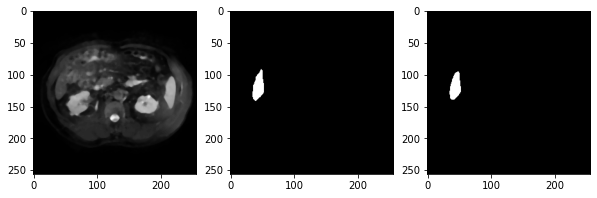

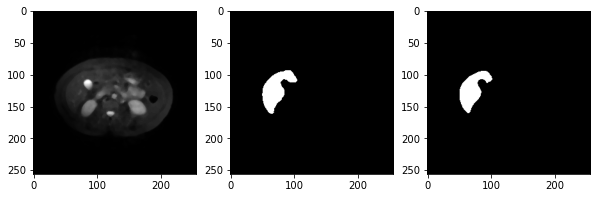

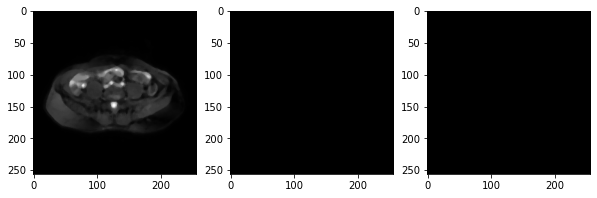

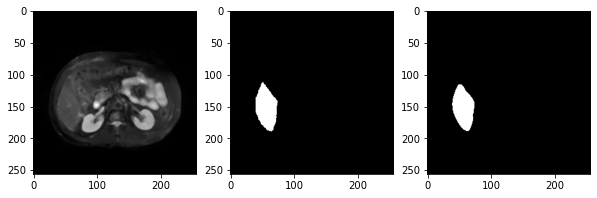

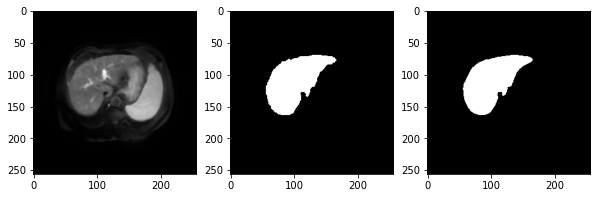

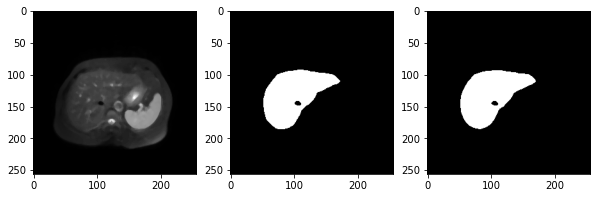

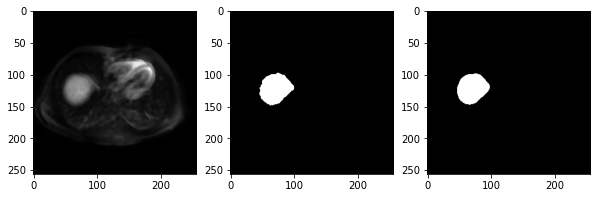

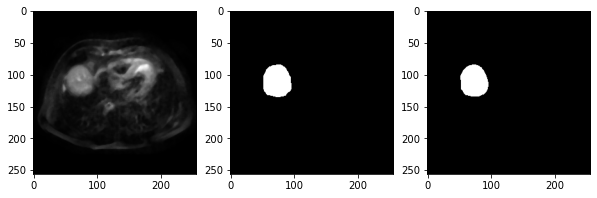

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


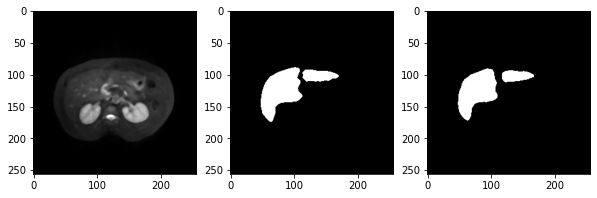

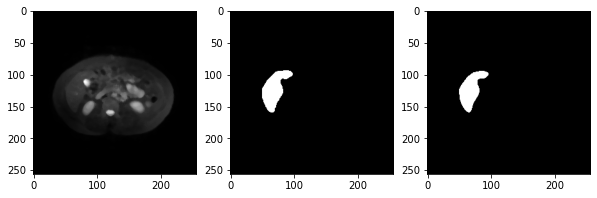

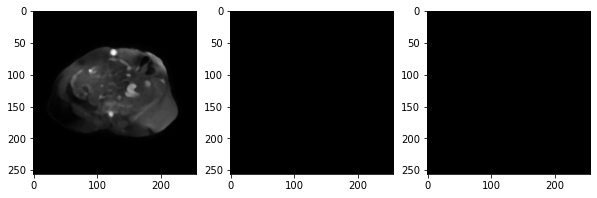

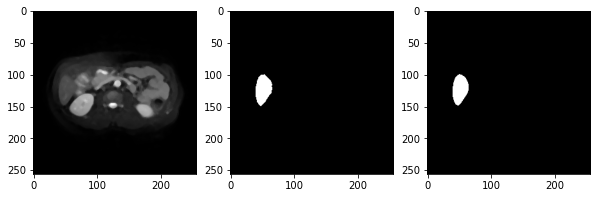

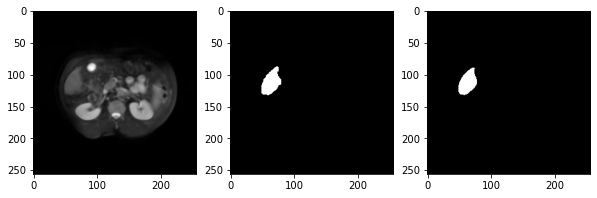

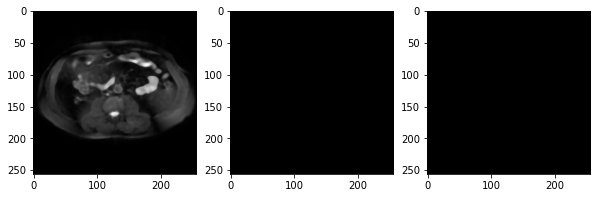

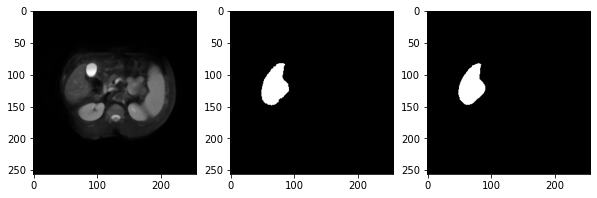

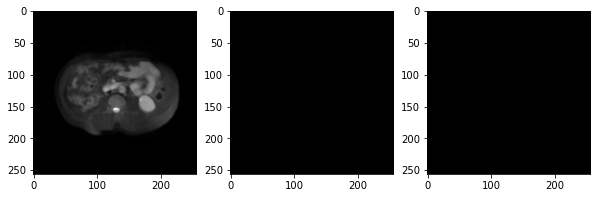

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


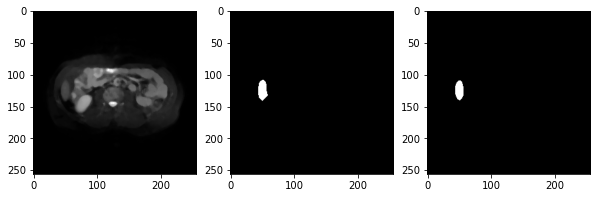

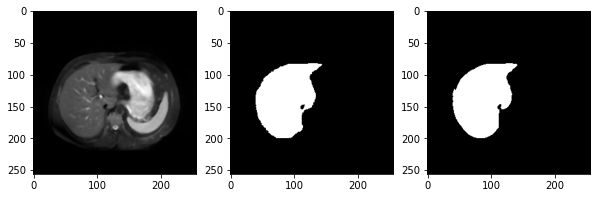

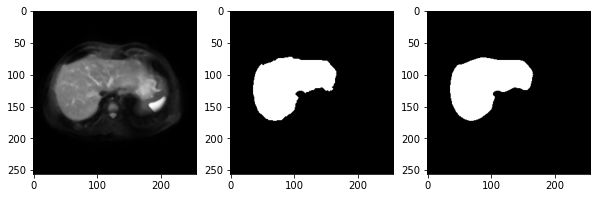

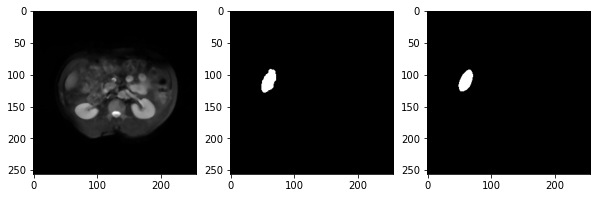

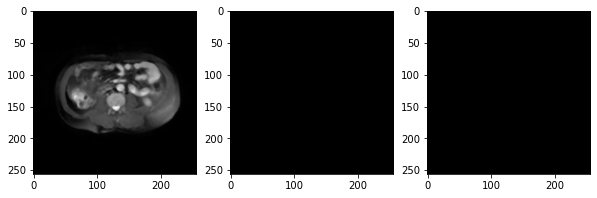

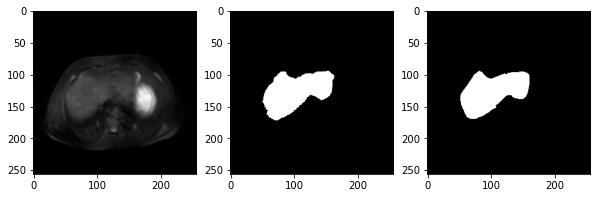

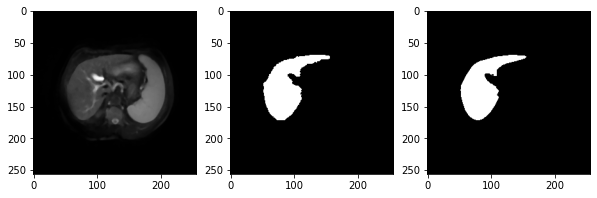

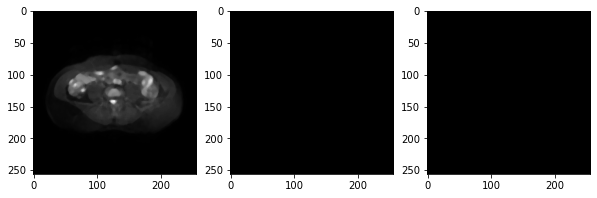

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


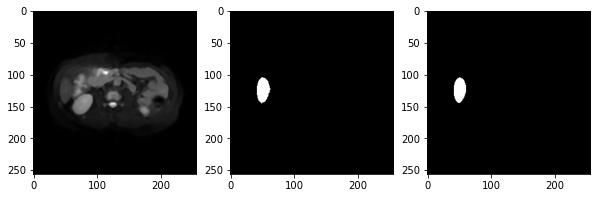

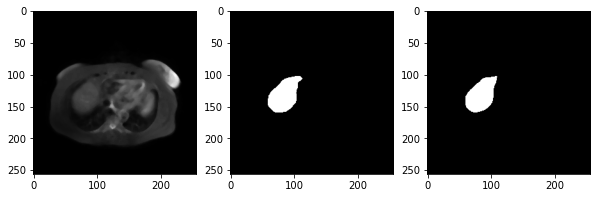

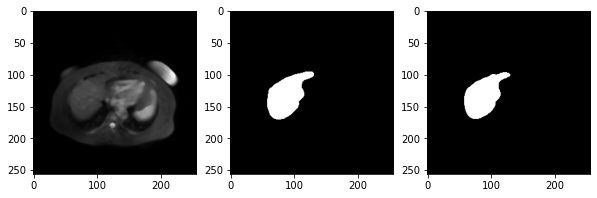

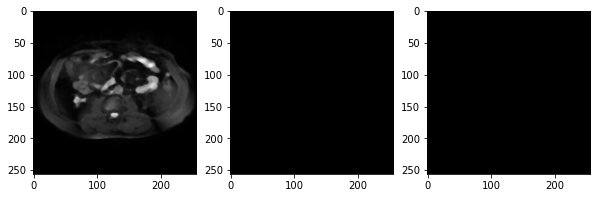

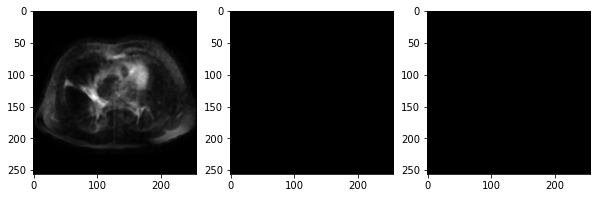

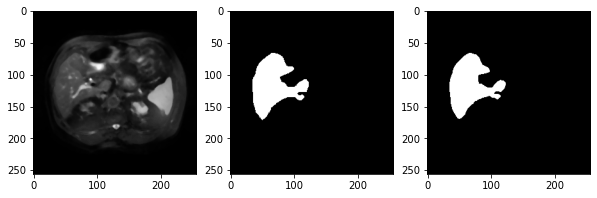

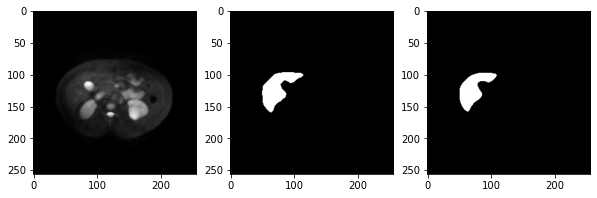

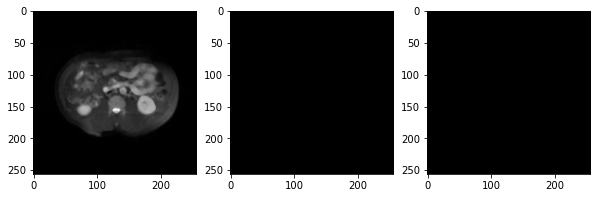

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


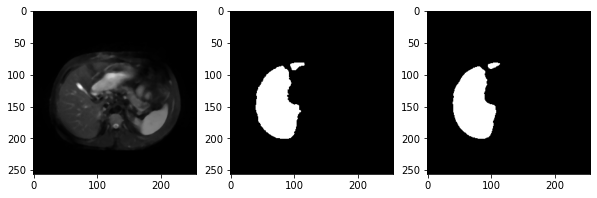

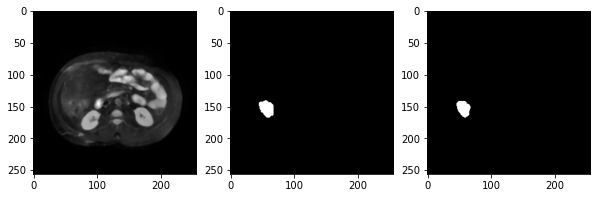

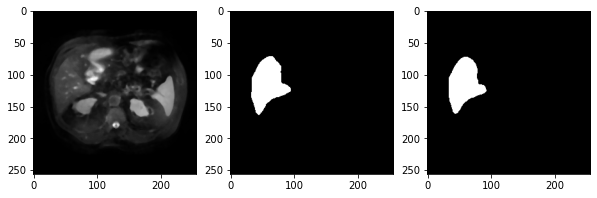

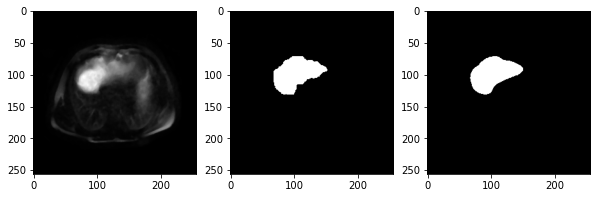

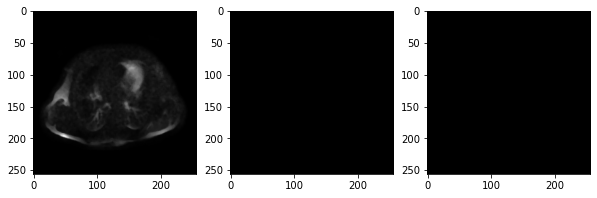

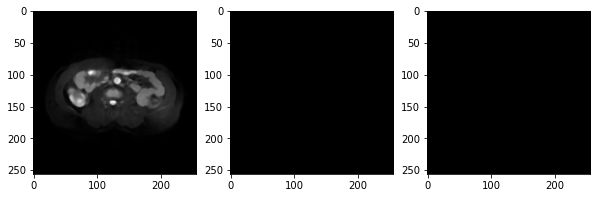

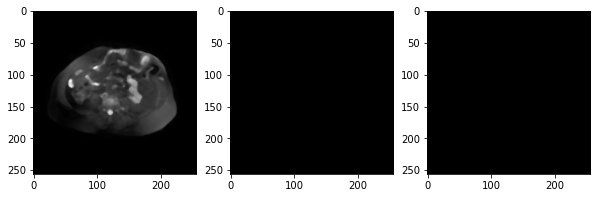

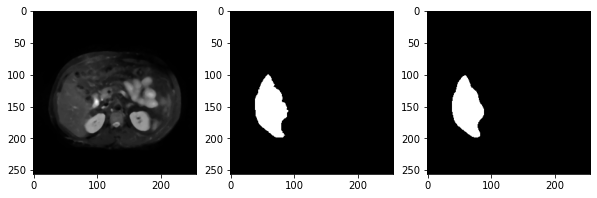

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


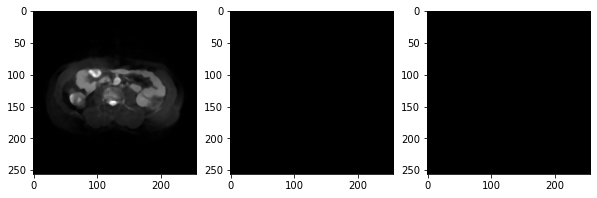

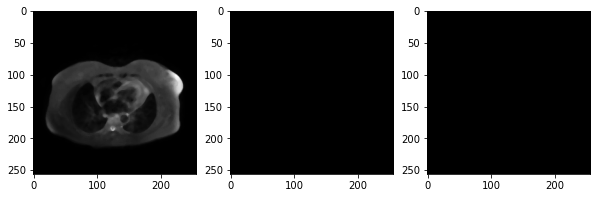

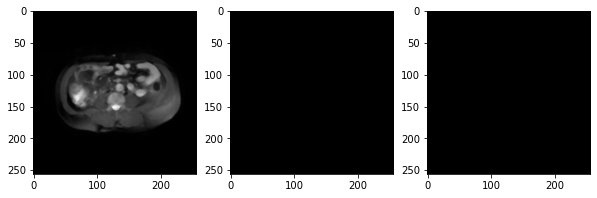

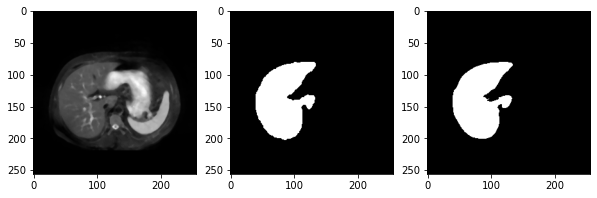

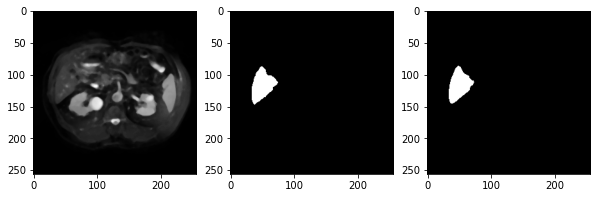

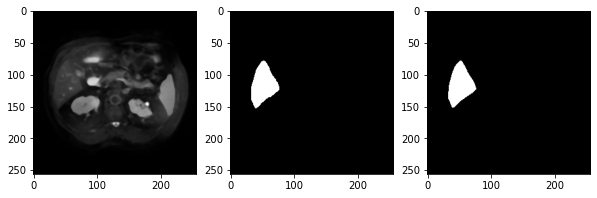

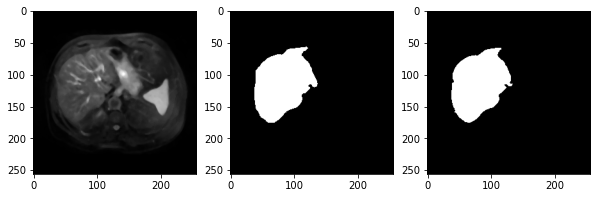

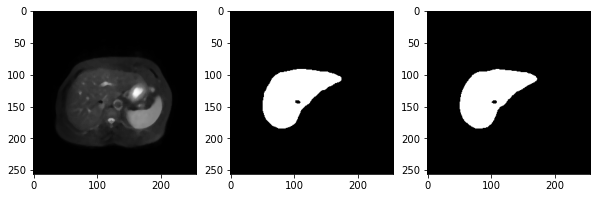

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


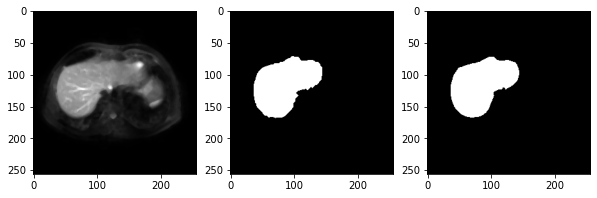

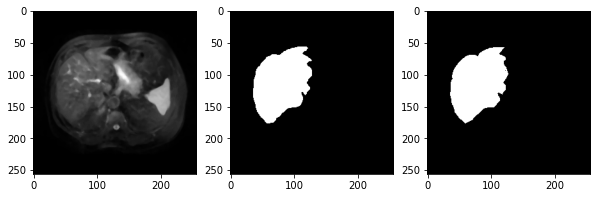

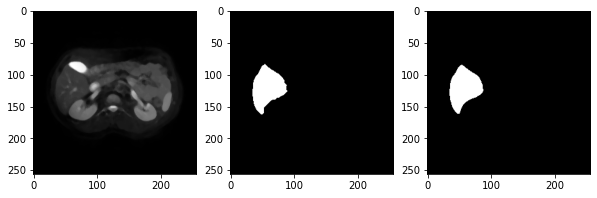

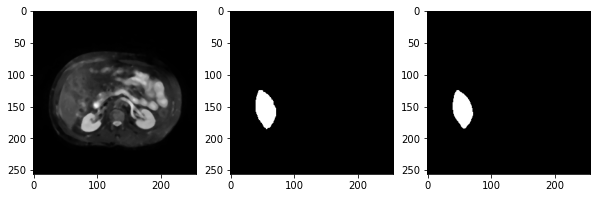

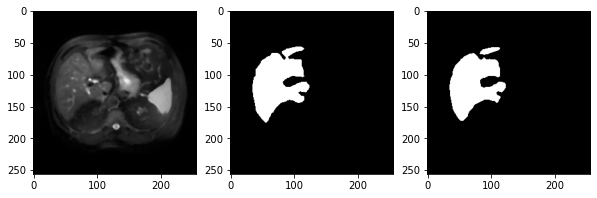

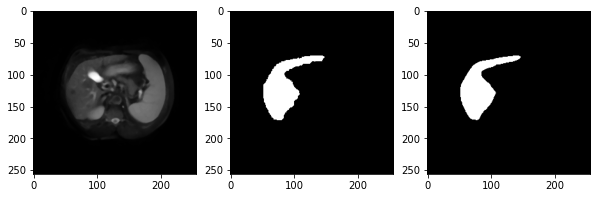

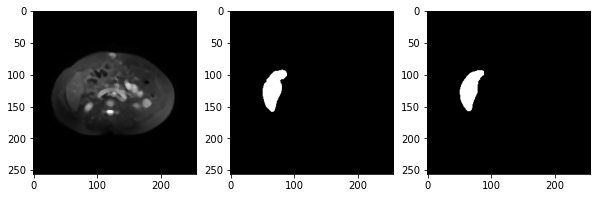

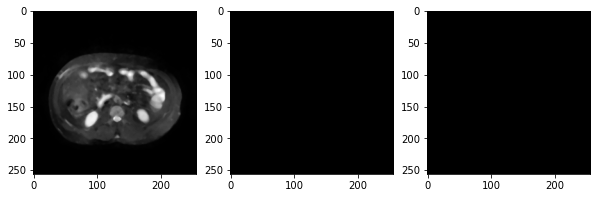

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


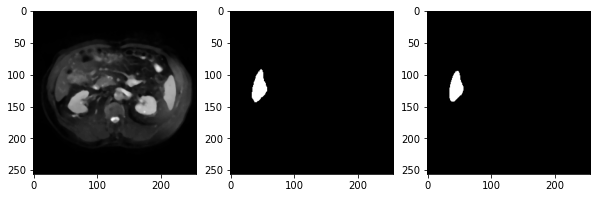

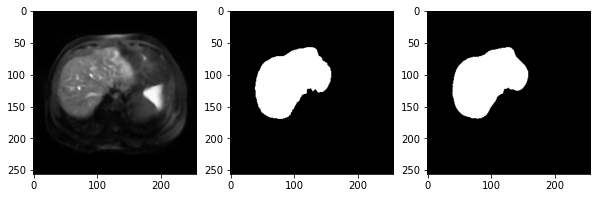

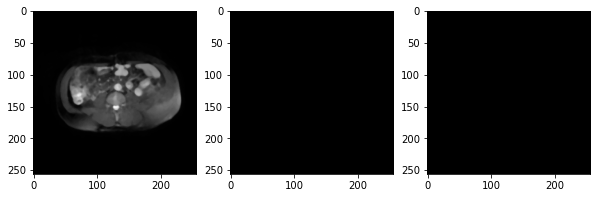

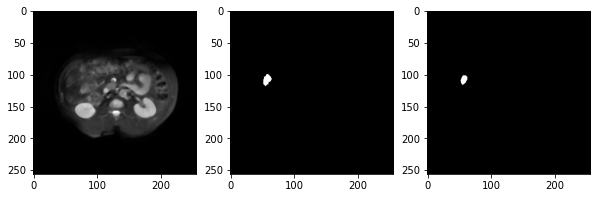

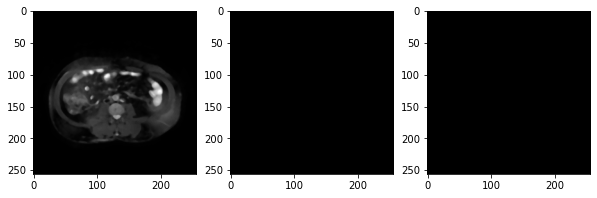

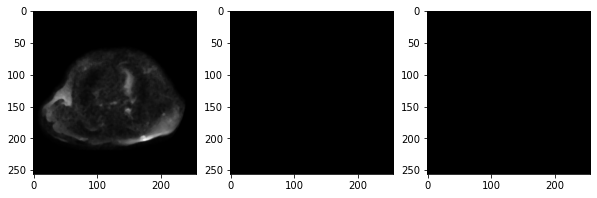

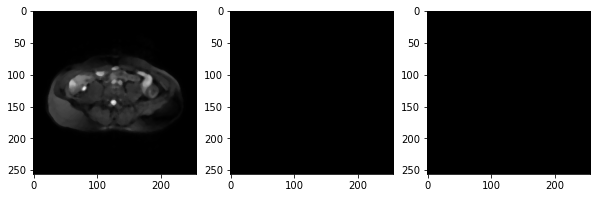

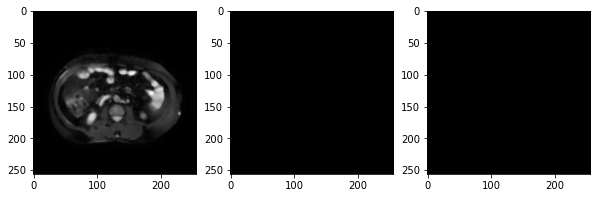

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


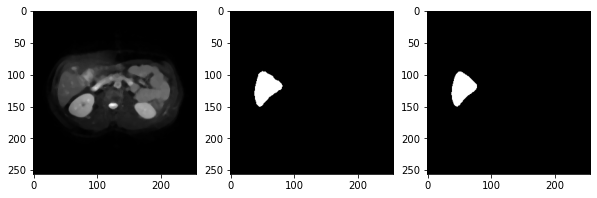

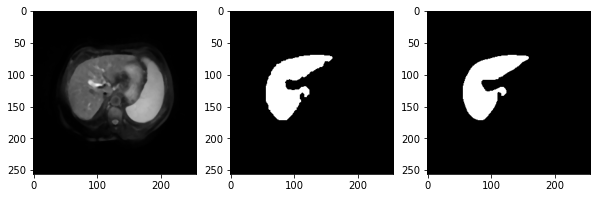

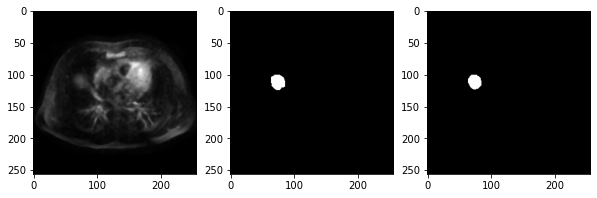

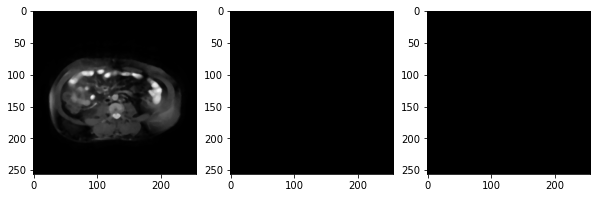

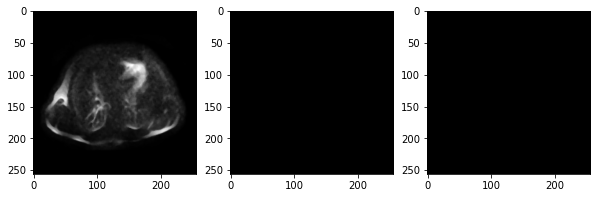

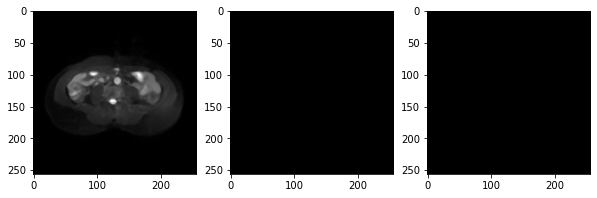

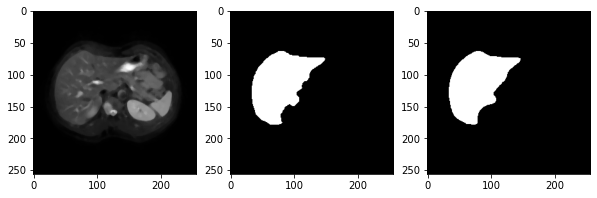

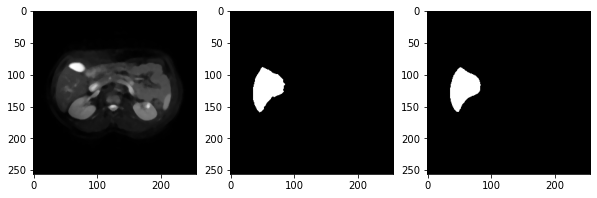

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


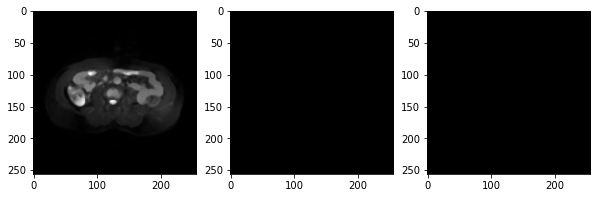

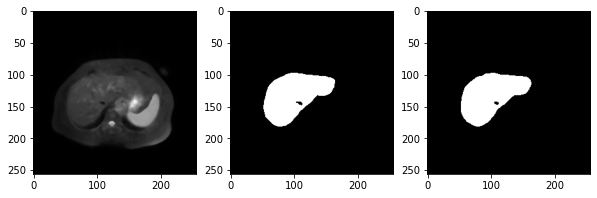

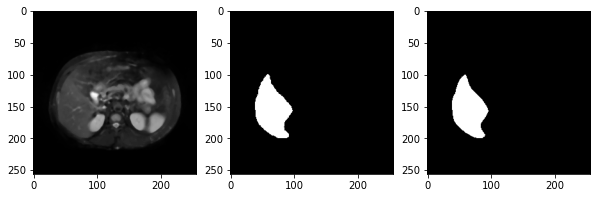

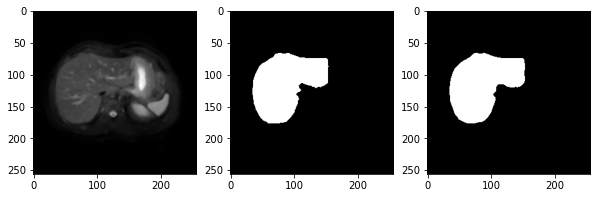

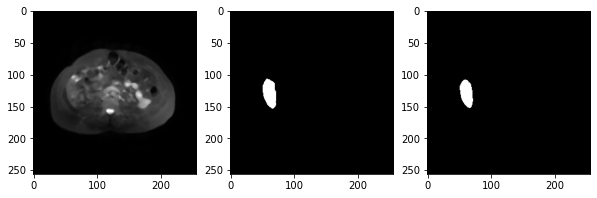

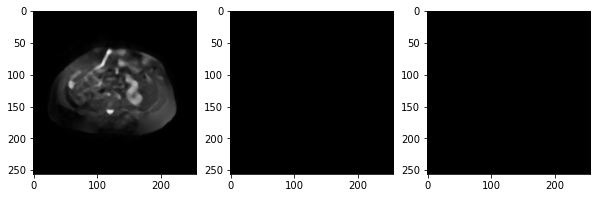

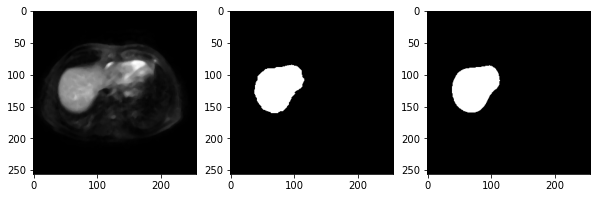

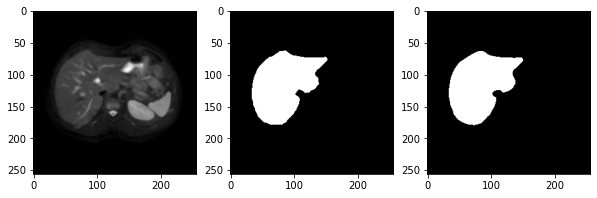

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


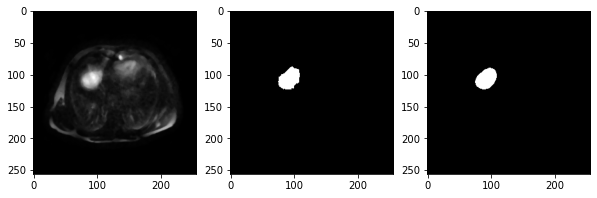

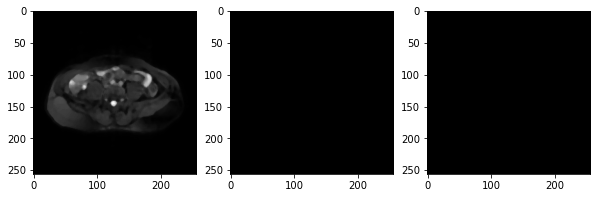

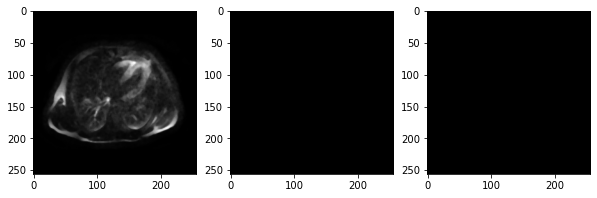

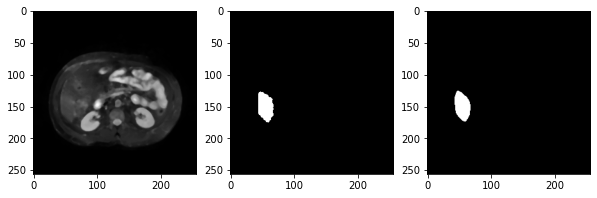

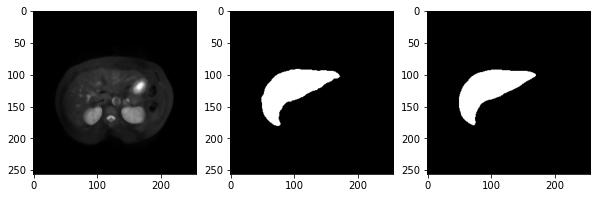

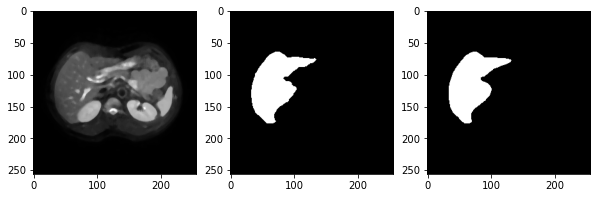

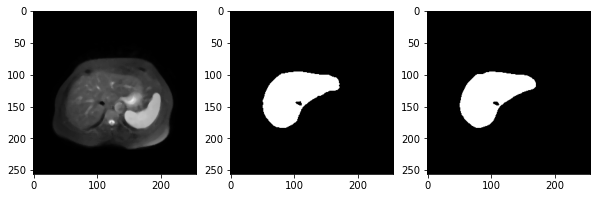

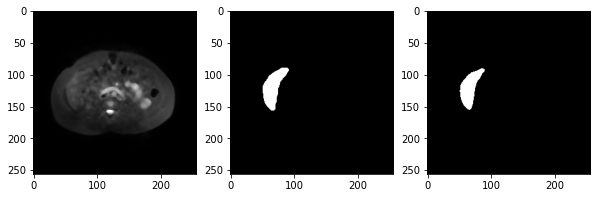

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


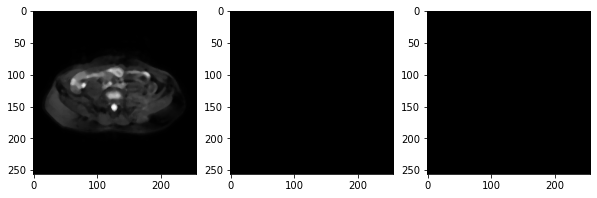

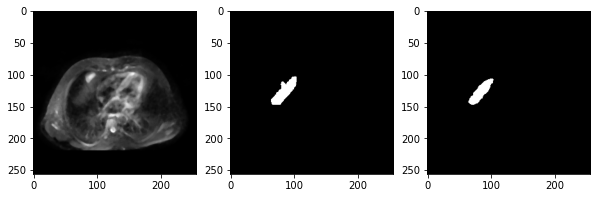

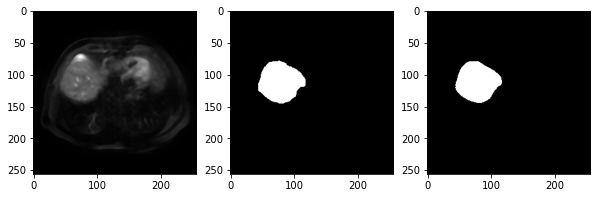

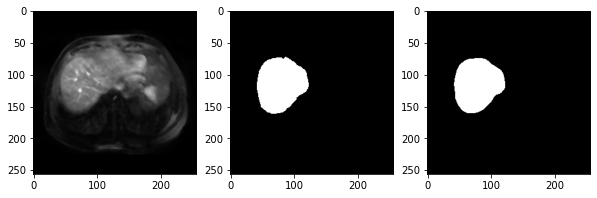

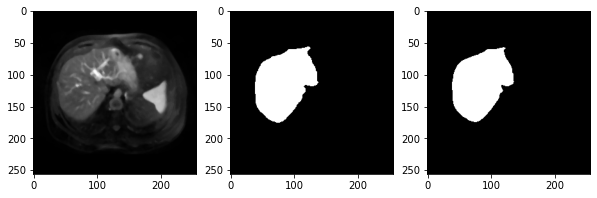

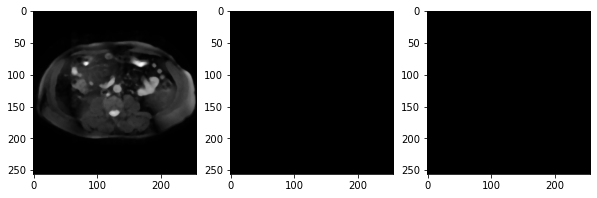

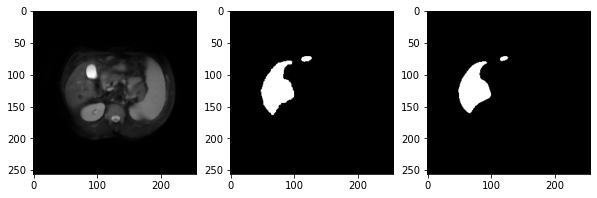

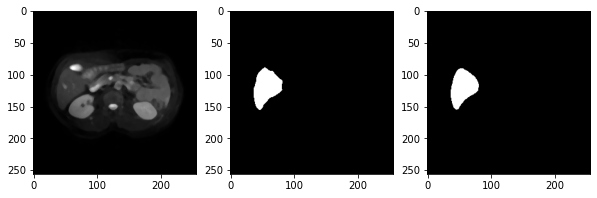

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


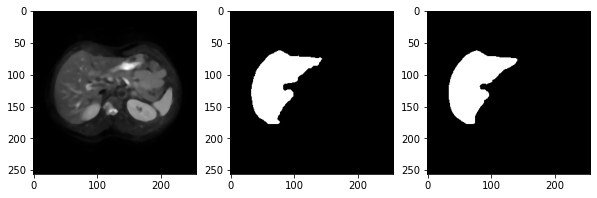

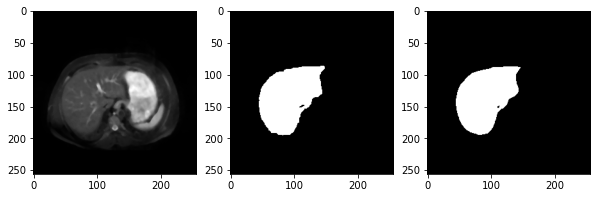

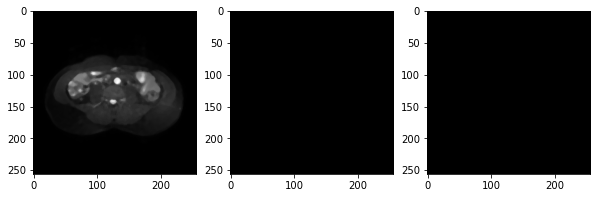

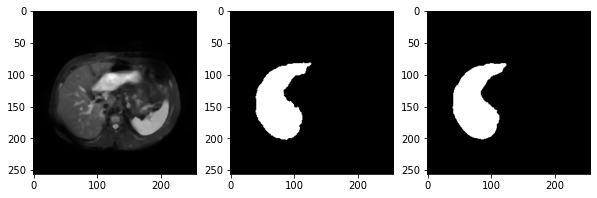

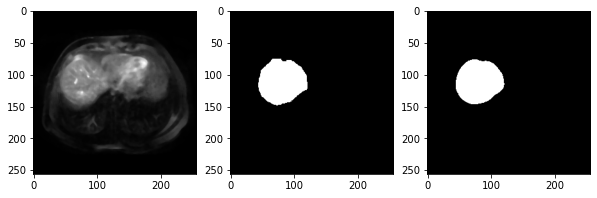

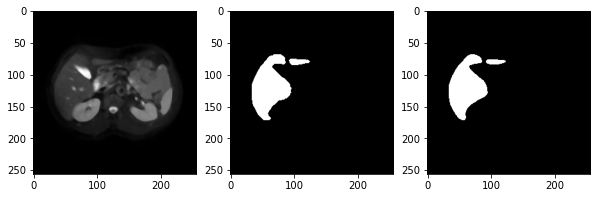

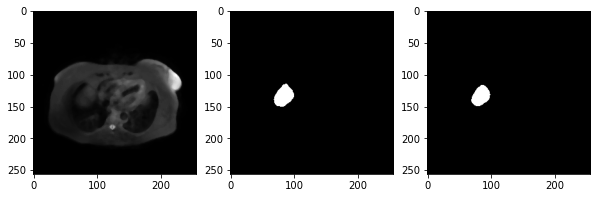

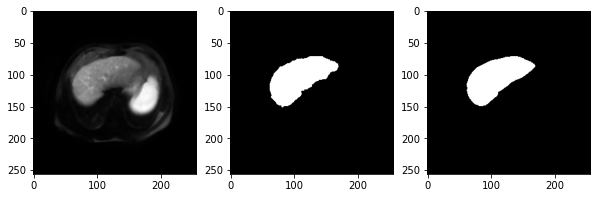

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


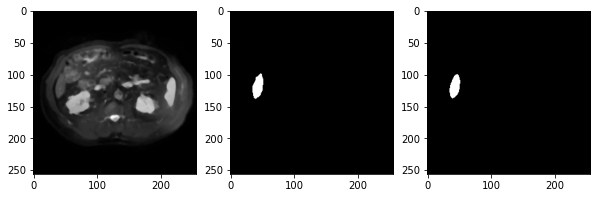

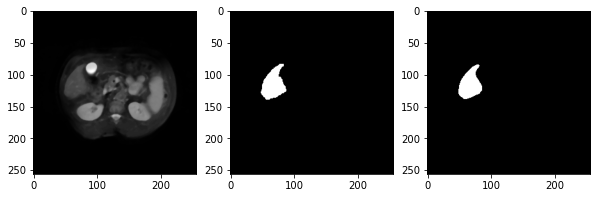

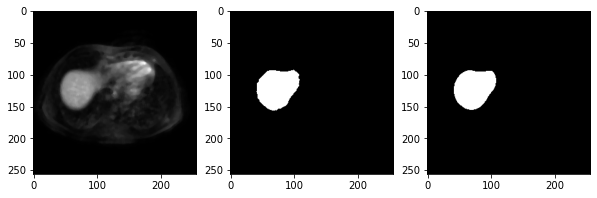

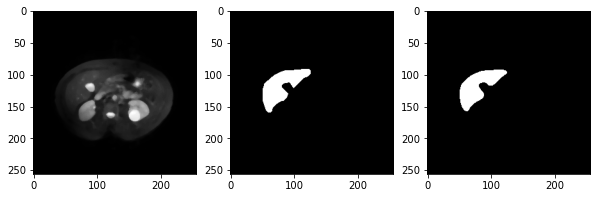

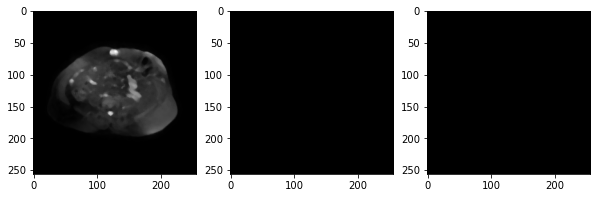

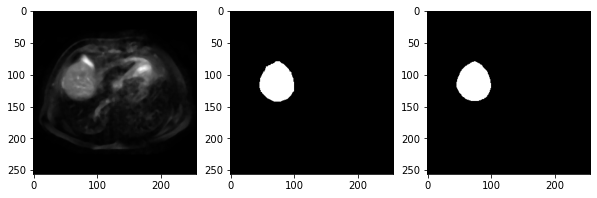

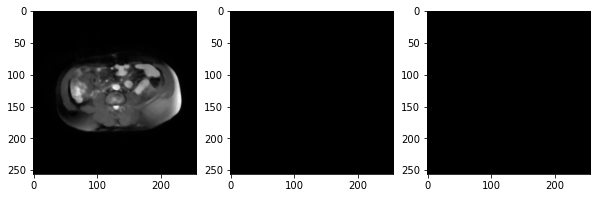

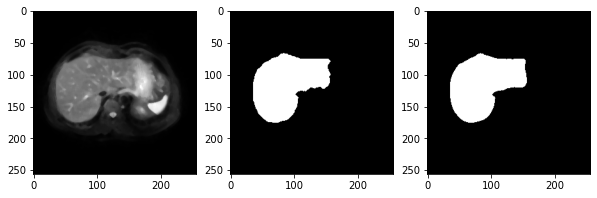

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


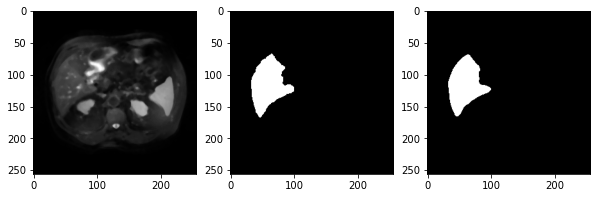

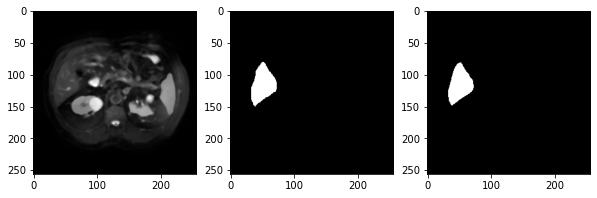

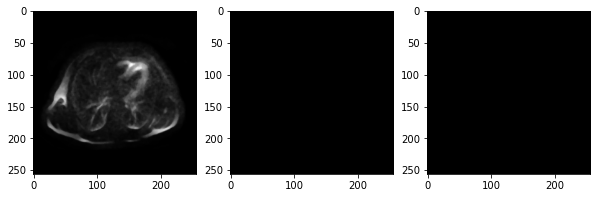

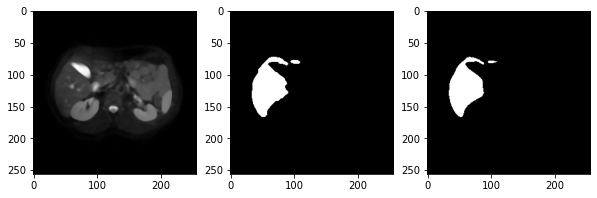

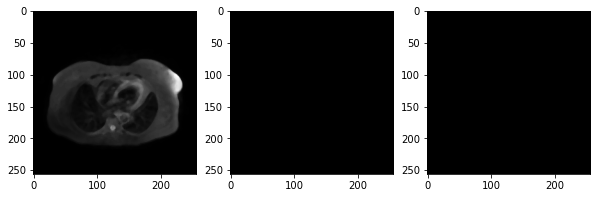

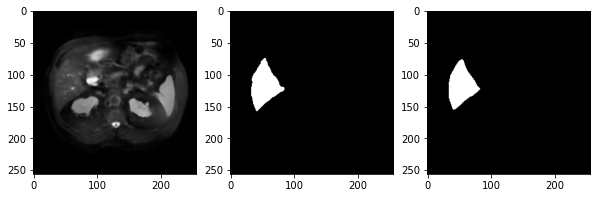

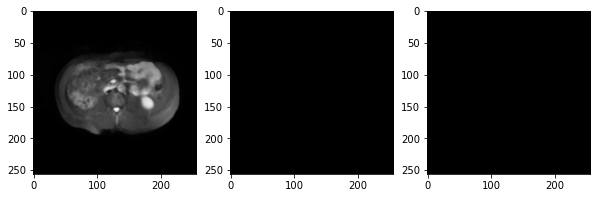

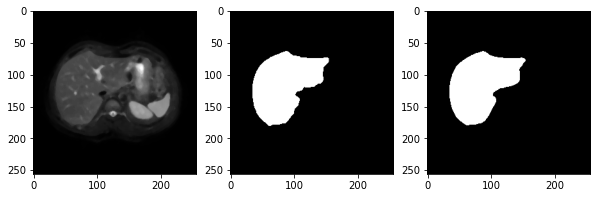

In [13]:
'''
abs: testing model
---
'''

for i, data in enumerate(dataloader_train, 1):
    image, mask = data
    print(len(image), image.shape, mask.shape)
    with torch.no_grad():
        image = image.to(device)
        mask = mask.to(device)
        outputs = model(image)

    'single channel'
    threshold = 0
    outputs[outputs>=threshold] = 1.
    outputs[outputs!=1] = 0.

    img_process = lambda image:image.squeeze(1).cpu().numpy()
    mask_process = lambda mask:mask.squeeze(1).cpu().numpy()

    
    for x, m, outputs in zip(img_process(image), mask_process(mask), mask_process(outputs)):
        show_image(x, m, outputs)
        break
            
    del outputs, image, mask

In [11]:
import os
from IPython import get_ipython
if __name__ == '__main__':
    if get_ipython().__class__.__name__ =='ZMQInteractiveShell':
        os.system('jupyter nbconvert train_unet.ipynb --to python')

[NbConvertApp] Converting notebook train_unet.ipynb to python
[NbConvertApp] Writing 7037 bytes to train_unet.py
